# import 

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json, html, re
import numpy as np
from tqdm import tqdm
from glob import glob
from collections import Counter
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath
from datetime import timedelta, datetime
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
STOPWORDS = thai_stopwords()

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font_path = '/Users/Nozomi/Library/Fonts/THSarabunNew.ttf'
font_label = fm.FontProperties(fname=font_path,weight='bold',size=25)

def clean(text, hashtag=None):
    if hashtag:
        text = text.replace(hashtag, '')
    text = html.unescape(text)
    text = re.sub(r'http.+?(?:\\s|$)', '', text) # URL link
    text = re.sub(r'[“”„]', '"', text) # convert double quotations into "
    text = re.sub(r'[‘’′′′′`]', "'", text) # convert single quotations into '
    text = re.sub(r'[ \u00a0\xa0\u3000\u2002-\u200a\t\n#]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'ํา','ำ', text) # am
    return text.strip()

def tokenize(text, hashtag=None):
    tokens = word_tokenize(clean(text, hashtag), keep_whitespace='False')
    tokens = [token for token in tokens if token not in STOPWORDS and re.match(r'[ก-๙][ก-๙\\.\\-]+$', token)]
    return tokens

def get_hour(row, string=True):
    date = datetime(row.date.year, row.date.month, row.date.day, int(row.time[:2]))
    if string:
        return str(date)[:-3] # '2021-04-09 22:00'
    else:
        return date # datetime.datetime(2021, 4, 9, 22, 0)

    
def timerange(df):
    oldest = get_hour(df.iloc[len(df)-1], False)
    latest = get_hour(df.iloc[0], False)
    range_list = [str(oldest)]
    while range_list[-1] != str(latest):
        oldest = oldest + timedelta(hours=1)
        range_list.append(str(oldest))
    return pd.DataFrame(range_list, columns=['date'])

def timerange_day(df):
    oldest = df.iloc[len(df)-1].date
    latest = df.iloc[0].date
    range_list = [str(oldest).split()[0]]
    while range_list[-1] != str(latest).split()[0]:
        oldest = oldest + timedelta(days=1)
        range_list.append(str(oldest).split()[0])
    return pd.DataFrame(range_list, columns=['date'])

In [2]:
!ls tweets

#16ตุลาไปแยกปทุมวัน.csv
#16ตุลาไปแยกปทุมวัน.json
#25พฤศจิกาไปSCB.csv
#25พฤศจิกาไปSCB.json
#saveวันเฉลิม.csv
#saveวันเฉลิม.json
#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.csv
#ม็อบ25พฤศจิกาทวงคืนสมบัติชาติ.json
#ม็อบ2ธันวา.csv
#ม็อบ2ธันวา.json
#ธรรมศาสตร์และการชุมนุม.csv
#ธรรมศาสตร์และการชุมนุม.json
#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.csv
#เกียมอุดมไม่ก้มหัวให้เผด็จการ.csv
#กูสั่งให้มึงอยู่ใต้รัฐธรรมนูญ.json
#เกียมอุดมไม่ก้มหัวให้เผด็จการ.json
badstudent_tweet.csv
badstudent_tweet.json
badstudent_tweet_raw.csv
freeyouth_tweet.csv
freeyouth_tweet.json
freeyouth_tweet_raw.csv
tanawatofficial_tweet.csv
tanawatofficial_tweet.json
tanawatofficial_tweet_raw.csv
thammasatUFTD_tweet.csv
thammasatUFTD_tweet.json
thammasatUFTD_tweet_raw.csv
แฮมทาโร่.csv
แฮมทาโร่.json
แฮมทาโร่_hashtag.csv
แฮมทาโร่_hashtag_tokenized.json
แฮมทาโร่_tokenized.json
ประเทศกูมี.csv
ประเทศกูมี.json
ประเทศกูมี_tokenized.json
ม็อบมุ้งมิ้ง.csv
แบนแทกุกไลน์.csv
ม็อบมุ้งมิ้ง.json
แบนแทกุกไลน์.json
ม็อบมุ้งมิ้ง_hashtag.csv
แบนแทกุกไลน์_hashtag.

In [3]:
filename = 'tweets/ประเทศกูมี.json'
filename = 'tweets/ถ้าการเมืองดี.json'
#filename = 'tweets/ให้มันจบที่รุ่นเรา.json'
num = 20

# tokenize

In [4]:
df = pd.read_json(filename, lines=True).drop_duplicates('id')
df = df.reset_index(drop=True)

### define duration ###
df = df[(df.date >= '2020-1-1') & (df.date < '2021-03-01')]

### tokenize ###
df['tokens'] = df.tweet.apply(lambda x: tokenize(x))
df

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens
0,1366070107949002752,1366070107949002752,2021-02-28 16:57:48,2021-02-28,23:57:48,700,1094636499511869441,yeppeunryuna13,; yunaverse #LOCO,,...,,,,,[],,,,,"[มีเรื่อง, ม็อบ, แอนตี้, เหี้ย, บูล, ลี่, ถาโถ..."
1,1366069671208755202,1366067044655849472,2021-02-28 16:56:04,2021-02-28,23:56:04,700,933178265178484738,haveabkppday,🎀มิ้นโน๊ะ🎀,,...,,,,,[],,,,,"[สลิ่ม, ช่าง, กล้า, ช่าง, มั่น, เนอะ, เรื่อง, ..."
2,1366069638627397632,1366069638627397632,2021-02-28 16:55:56,2021-02-28,23:55:56,700,1233000287981334528,kanhom1135,ก้านหอม กู้ดบอย*,,...,,,,,[],,,,,"[การเมือง, ดี, เดี๋ยว, ผัว]"
3,1366069581442211840,1366069581442211840,2021-02-28 16:55:43,2021-02-28,23:55:43,700,1152954640331243526,ddoremeee,ddoreme✨ — 🌷🖇,,...,,,,,[],,,,,"[สื่อ, ทำ, แบบนี้, การเมือง, ดี, ก้คง, ต่อไป, ..."
4,1366069486470631424,1366069486470631424,2021-02-28 16:55:20,2021-02-28,23:55:20,700,1291902052168118273,mdluvbwu,ชาชา III,,...,,,,,[],,,,,"[วก, ด่า, ตำรวจ, ๆๆๆ, การเมือง, ดี]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126036,1212735218617995266,1211557321597313024,2020-01-02 13:59:42,2020-01-02,20:59:42,700,948972629636956161,star75225960,ทิ้งไวกลางทาง,,...,,,,,"[{'screen_name': 'johnwinyu', 'name': 'John Wi...",,,,,"[หมา, ดีกว่า, ตา, ลุง, คน, ลุง, เล่นการเมือง, ..."
126037,1212446213993160704,1212446213993160704,2020-01-01 18:51:18,2020-01-02,01:51:18,700,775321083943591936,khingpitcha,Minny,,...,,,,,[],,,,,"[เกาหลี, สุดยอด, แม่, รู้, ดู, ตะลึง, พระเอก, ..."
126038,1212412674958487552,1212412674958487552,2020-01-01 16:38:01,2020-01-01,23:38:01,700,3265736412,dearmissjanedoe,Jane Doe lll,,...,,,,,[],,,,,"[มุมมอง, เรื่องราว, ได้ดี, เรื่อง, สามัญ, เรื่..."
126039,1212351077653176320,1212351077653176320,2020-01-01 12:33:15,2020-01-01,19:33:15,700,2351874080,swifties378,"19 พฤศจิ—Red(Taylor’s ver.) .|||, ☔︎︎",,...,,,,,[],,,,,"[บ้าน, ดู, เนชั่น, แล้วก็, เมือง, ไทย, อะ, เจร..."


# save

In [5]:
df.to_json(filename.replace('.json','_tokenized.json'), orient='records')

In [6]:
column = ['date','time','username','tweet','hashtags','link','quote_url','urls','photos','thumbnail','mentions','reply_to','replies_count','retweets_count','likes_count']
df[column].to_csv(filename.replace('.json','.csv'), index=False)

# frequent hashtag & cooccurent words

In [16]:
df = pd.read_json(filename.replace('.json','_tokenized.json'))


##### hashtags #####
hashtag_counter = Counter()
for lst in tqdm(df.hashtags):
    hashtag_counter.update(lst)
    
hashtag2word = {x[0]:Counter() for x in hashtag_counter.most_common(num)}

# count frequent words
for i, row in tqdm(df.iterrows()):
    for hashtag in row['hashtags']:
        if hashtag in hashtag2word:
            hashtag2word[hashtag].update(row['tokens'])
    
print("|co-hashtag|count|frequent words|oldest|popular|\n|:-:|:-:|:-:|:-:|:-:|")
for tag, c, in hashtag_counter.most_common(num):
    tempdf = df[df.hashtags.apply(lambda x: tag in x)].sort_values(['created_at'])
    
    ## frequent words
    freqs = " ".join([f"{w}({c})" for w,c in hashtag2word[tag].most_common(10)])
    
    ## oldest
    oldest = tempdf.iloc[0].tweet
    oldest_name = tempdf.iloc[0].username
    oldest_link = tempdf.iloc[0].link
    oldest_date = str(tempdf.iloc[0]['created_at']).split('+')[0]
    
    ## popular
    tempdf = tempdf.sort_values(["retweets_count"], ascending=False)
    popular = tempdf.iloc[0].tweet
    popular_name = tempdf.iloc[0].username
    popular_link = tempdf.iloc[0].link
    popular_date = str(tempdf.iloc[0]['created_at']).split('+')[0]
    retweet_count = tempdf.iloc[0].retweets_count
    
    print(f"|#{tag}|{c}|{freqs}|[{oldest_date}]({oldest_link})<br>[@{oldest_name}](https://twitter.com/{oldest_name})<br><br>{oldest.replace('|||','')}|[{popular_date}]({popular_link})<br>[@{popular_name}](https://twitter.com/{popular_name})<br>{retweet_count} retweets<br><br>{popular.replace('|||','')}|")

100%|██████████| 126041/126041 [00:00<00:00, 243394.48it/s]
126041it [00:21, 5957.93it/s]


|co-hashtag|count|frequent words|oldest|popular|
|:-:|:-:|:-:|:-:|:-:|
|#ถ้าการเมืองดี|47504|ดี(57374) การเมือง(51484) คน(8698) ไม่ต้อง(7421) ประเทศ(5199) ม็อบ(5058) ทำ(4461) ประชาชน(4084) ไทย(3856) แบบนี้(3683)|[2020-07-19 06:20:49](https://twitter.com/InfinitaSub/status/1284734923811590144)<br>[@infinitasub](https://twitter.com/infinitasub)<br><br>เรามาเล่นแทกอะไรกันไหมคะ?   #ถ้าการเมืองดี เราจะมีเงินเดือนที่สูงขึ้น บัตรคอน 5-6-7 พันเหรอ เหอะ! สบายจ้าาาาาาาาาาา|[2020-08-14 02:43:30](https://twitter.com/paolonapaul/status/1294102319664001024)<br>[@paolonapaul](https://twitter.com/paolonapaul)<br>89671 retweets<br><br>ต่อให้รถติด แต่รถสาธารณะต้องไม่ติด  . #เกาหลี #ถ้าการเมืองดี #ขนส่งจะดี #คนเดินเท้า  https://t.co/SrVuemU1Kc|
|#เยาวชนปลดเเอก|2091|ดี(2258) การเมือง(2221) เยาวชน(2129) ปลด(2104) เอก(2100) จบ(824) รุ่น(793) คน(397) พร(355) สู้(303)|[2020-07-18 19:58:48](https://twitter.com/pppsubmarine/status/1284578387952955392)<br>[@pppsubmarine](https://twitter.com/pppsubmarine)<br><br>

In [8]:
df = df.reset_index(drop=True)
df

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens
0,1366070107949002752,1366070107949002752,2021-02-28 16:57:48,2021-02-28,23:57:48,700,1094636499511869441,yeppeunryuna13,; yunaverse #LOCO,,...,,,,,[],,,,,"[มีเรื่อง, ม็อบ, แอนตี้, เหี้ย, บูล, ลี่, ถาโถ..."
1,1366069671208755202,1366067044655849472,2021-02-28 16:56:04,2021-02-28,23:56:04,700,933178265178484738,haveabkppday,🎀มิ้นโน๊ะ🎀,,...,,,,,[],,,,,"[สลิ่ม, ช่าง, กล้า, ช่าง, มั่น, เนอะ, เรื่อง, ..."
2,1366069638627397632,1366069638627397632,2021-02-28 16:55:56,2021-02-28,23:55:56,700,1233000287981334528,kanhom1135,ก้านหอม กู้ดบอย*,,...,,,,,[],,,,,"[การเมือง, ดี, เดี๋ยว, ผัว]"
3,1366069581442211840,1366069581442211840,2021-02-28 16:55:43,2021-02-28,23:55:43,700,1152954640331243526,ddoremeee,ddoreme✨ — 🌷🖇,,...,,,,,[],,,,,"[สื่อ, ทำ, แบบนี้, การเมือง, ดี, ก้คง, ต่อไป, ..."
4,1366069486470631424,1366069486470631424,2021-02-28 16:55:20,2021-02-28,23:55:20,700,1291902052168118273,mdluvbwu,ชาชา III,,...,,,,,[],,,,,"[วก, ด่า, ตำรวจ, ๆๆๆ, การเมือง, ดี]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126036,1212735218617995266,1211557321597313024,2020-01-02 13:59:42,2020-01-02,20:59:42,700,948972629636956161,star75225960,ทิ้งไวกลางทาง,,...,,,,,"[{'screen_name': 'johnwinyu', 'name': 'John Wi...",,,,,"[หมา, ดีกว่า, ตา, ลุง, คน, ลุง, เล่นการเมือง, ..."
126037,1212446213993160704,1212446213993160704,2020-01-01 18:51:18,2020-01-02,01:51:18,700,775321083943591936,khingpitcha,Minny,,...,,,,,[],,,,,"[เกาหลี, สุดยอด, แม่, รู้, ดู, ตะลึง, พระเอก, ..."
126038,1212412674958487552,1212412674958487552,2020-01-01 16:38:01,2020-01-01,23:38:01,700,3265736412,dearmissjanedoe,Jane Doe lll,,...,,,,,[],,,,,"[มุมมอง, เรื่องราว, ได้ดี, เรื่อง, สามัญ, เรื่..."
126039,1212351077653176320,1212351077653176320,2020-01-01 12:33:15,2020-01-01,19:33:15,700,2351874080,swifties378,"19 พฤศจิ—Red(Taylor’s ver.) .|||, ☔︎︎",,...,,,,,[],,,,,"[บ้าน, ดู, เนชั่น, แล้วก็, เมือง, ไทย, อะ, เจร..."


# hashtag timeseries

100%|██████████| 7/7 [02:33<00:00, 21.95s/it]


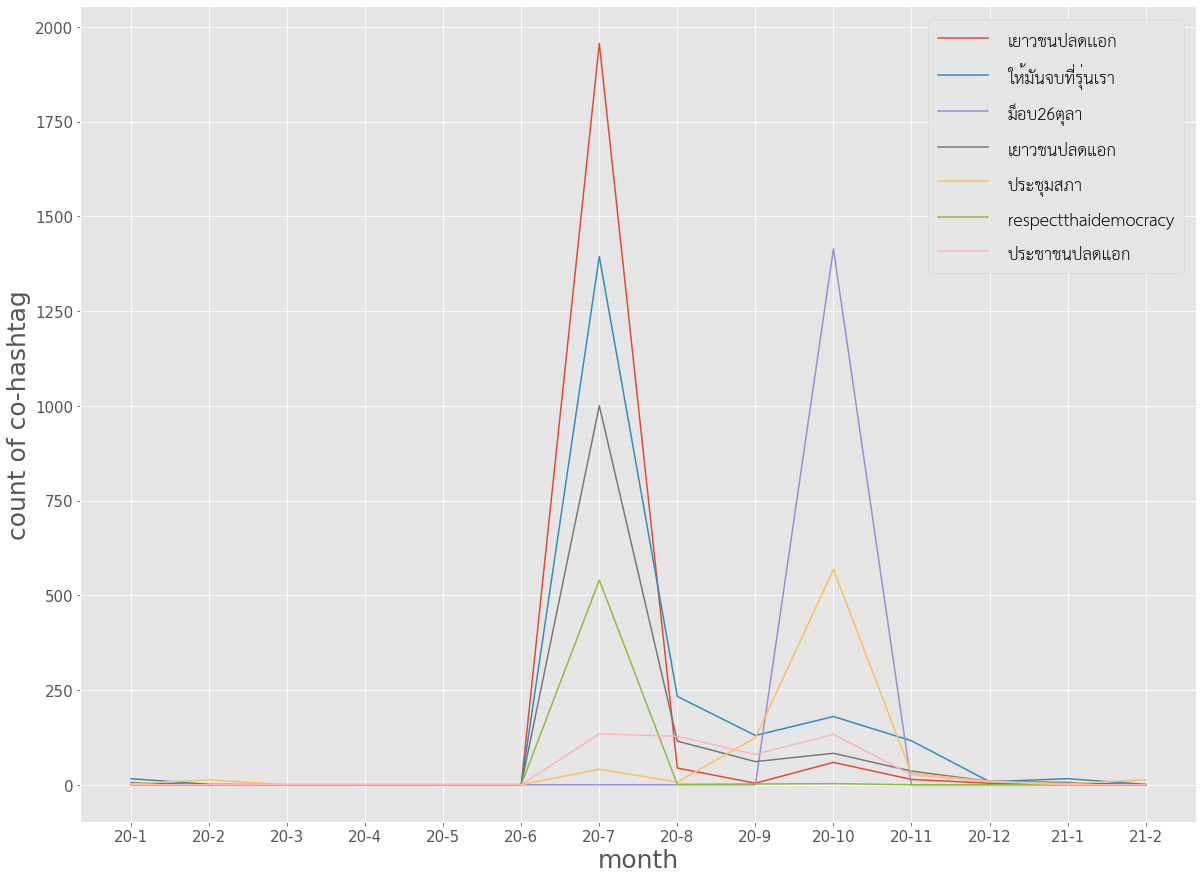

In [15]:
### plot time series ###

start_m = 1
months = [f'20-{m}' for m in range(start_m, 13)] + ['21-1','21-2']

fig = plt.figure(figsize=(20,15))

for tag, count in tqdm(hashtag_counter.most_common(8)[1:]): # exclude original hashtag
    counts = []  
    for y_m in months:
        y = int('20' + y_m.split('-')[0])
        m = int(y_m.split('-')[1])
        count = 0
        thismonth_df = df[df.date.dt.month == m]
        for i, row in thismonth_df.iterrows():
            if tag in row['hashtags']:
                count += 1
        counts.append(count)

    plt.plot(months, counts, label=tag)

plt.xticks(months, size=15)
plt.yticks(size=15)
plt.legend(prop=font_label)
plt.xlabel('month', size=25)
plt.ylabel('count of co-hashtag', size=25)
plt.show()

# LDA

In [ ]:
%%time

##### TRAIN #####

num_topic = 5

corpus_dictionary = Dictionary(df.tokens)
corpus = []
for tokens_list in tqdm(df.tokens):
    corpus.append(corpus_dictionary.doc2bow(tokens_list))
lda = LdaModel(corpus, num_topics=num_topic, id2word=corpus_dictionary, passes=10)

100%|██████████| 126041/126041 [00:03<00:00, 42008.60it/s]


In [ ]:
# Save  & Load

temp_file = datapath(filename.replace('tweets/','').replace('.json',''))
lda.save(temp_file)
#lda = LdaModel.load(temp_file)

In [ ]:
### print result of keywords ###
print('|rank|topic 1||topic 2||topic 3||topic 4||topic 5||\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i in range(10):
    print(f'|{i+1}', end='')
    for j in range(5):
        word, score = lda.show_topic(j)[i]
        print(f"|{word}|{score:.3f}",end="")
    print('|')

In [ ]:
### prediction - argmax ###

n = len(df)

result_matrix = np.zeros((n, num_topic))
for row, dist in enumerate(lda.get_document_topics(corpus[:n])):
    for tpl in dist:
        col = tpl[0]
        result_matrix[row,col] = tpl[1]
        
result_df = pd.DataFrame(result_matrix)
result_df['topic'] = result_df.apply(lambda row: np.argmax(row), axis=1)
result_df['tweet'] = df.tweet.reset_index(drop=True)
result_df['date'] = df.apply(lambda row: get_hour(row), axis=1).reset_index(drop=True)

result_df

In [ ]:
### print prediction ###

print('|tweet|topic|prob of 1|2|3|4|5|\n|:-:|:-:|:-:|:-:|:-:|:-:|:-:|')
for i, row in result_df[['tweet','topic',0,1,2,3,4]].sample(10).iterrows():
    print(f'|{row.tweet}|{row.topic+1}|{row[0]:.3f}|{row[1]:.3f}|{row[2]:.3f}|{row[3]:.3f}|{row[4]:.3f}|')

In [ ]:
### plot topic time series ###

tempdf = timerange_day(df)

for t in range(5):
    tempdf[t+1] = tempdf.date.apply(lambda x: sum((result_df.date <= x) & (result_df.topic==t)))
    
tempdf.plot(x='date', figsize=(20,15))
plt.legend(prop=font_label)
plt.ylabel('cumulative count', size=20)
plt.xlabel('datetime', size=20)
plt.xticks(rotation=40, size=15)
plt.yticks(size=15)
plt.yscale('log')
plt.show()

# network

In [ ]:
replydf = pd.DataFrame(columns=['replier','replyee','date'])

"""
### for reply or mention ###
for i, row in df.iterrows():
    for dic in row['reply_to']:
        replydf.loc[len(replydf)] = [row['username'], dic['screen_name']]
"""
        
### for quote_link ###
all_link = sorted(df.link)
count = 0
d = set()
for i, row in tqdm(df.iterrows()):
    replier = row['username']
    quote = row['quote_url']
    date = row['created_at']
    if quote in all_link:
        c += 1
        replyee = quote.split('/')[3]
        d.add(replyee)
        replydf.loc[len(replydf)] = [replier, replyee,date]